# Library & Download


---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install pillow

In [ ]:
# 모듈 불러오기

import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision import transforms

# Image Classifer를 위한 Dataset 클래스 정의
## Training 데이터 100 장(쿠로코 50장, 카가미 50장), 
## Test 데이터 20장(쿠로코 10장, 카가미 10장)으로 구성
---

In [ ]:
# Image Classifer를 위한 Dataset 클래스

class CustomImageDataset(Dataset):
    def read_data_set(self):

        all_img_files = []
        all_labels = []

        class_names = os.walk(self.data_set_path).__next__()[1]

        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.data_set_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if img is not None:
                    all_img_files.append(img_file)
                    all_labels.append(label)

        return all_img_files, all_labels, len(all_img_files), len(class_names)

    def __init__(self, data_set_path, transforms=None):
        self.data_set_path = data_set_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_data_set()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return {'image': image, 'label': self.labels[index]}

    def __len__(self):
        return self.length

# module 및 layer 정리
---

In [ ]:
class CustomConvNet(nn.Module):
    def __init__(self, num_classes):
        super(CustomConvNet, self).__init__()

        self.layer1 = self.conv_module(3, 16)
        self.layer2 = self.conv_module(16, 32)
        self.layer3 = self.conv_module(32, 64)
        self.layer4 = self.conv_module(64, 128)
        self.layer5 = self.conv_module(128, 256)
        self.gap = self.global_avg_pool(256, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.gap(out)
        out = out.view(-1, num_classes)

        return out

    def conv_module(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

    def global_avg_pool(self, in_num, out_num):
        return nn.Sequential(
            nn.Conv2d(in_num, out_num, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_num),
            nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))

# 하이퍼파라미터 튜닝
---

In [ ]:
hyper_param_epoch = 20
hyper_param_batch = 8
hyper_param_learning_rate = 0.001

transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomRotation(10.),
                                       transforms.ToTensor()])

transforms_test = transforms.Compose([transforms.Resize((128, 128)),
                                      transforms.ToTensor()])

train_data_set_path = "/content/drive/MyDrive/Colab Notebooks/Simpson Project/data/data/train"
test_data_set_path = "/content/drive/MyDrive/Colab Notebooks/Simpson Project/data/data/test"

train_data_set = CustomImageDataset(data_set_path=train_data_set_path, transforms=transforms_train)
train_loader = DataLoader(train_data_set, batch_size=hyper_param_batch, shuffle=True)

test_data_set = CustomImageDataset(data_set_path=test_data_set_path, transforms=transforms_test)
test_loader = DataLoader(test_data_set, batch_size=hyper_param_batch, shuffle=True)

if not (train_data_set.num_classes == test_data_set.num_classes):
    print("error: Numbers of class in training set and test set are not equal")
    exit()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

num_classes = train_data_set.num_classes
custom_model = CustomConvNet(num_classes=num_classes).to(device)


# 모델 학습
---

In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=hyper_param_learning_rate)

for e in range(hyper_param_epoch):
    for i_batch, item in enumerate(train_loader):
        images = item['image'].to(device)
        labels = item['label'].to(device)

        # Forward pass
        outputs = custom_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i_batch + 1) % hyper_param_batch == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'
                  .format(e + 1, hyper_param_epoch, loss.item()))


Epoch [1/20], Loss: 0.3818
Epoch [2/20], Loss: 0.3413
Epoch [3/20], Loss: 0.3381
Epoch [4/20], Loss: 0.3332
Epoch [5/20], Loss: 0.2947
Epoch [6/20], Loss: 0.3024
Epoch [7/20], Loss: 0.2817
Epoch [8/20], Loss: 0.2937
Epoch [9/20], Loss: 0.2868
Epoch [10/20], Loss: 0.2795
Epoch [11/20], Loss: 0.4715
Epoch [12/20], Loss: 0.2589
Epoch [13/20], Loss: 0.2666
Epoch [14/20], Loss: 0.2625
Epoch [15/20], Loss: 0.2935
Epoch [16/20], Loss: 0.2326
Epoch [17/20], Loss: 0.2451
Epoch [18/20], Loss: 0.3709
Epoch [19/20], Loss: 0.2860
Epoch [20/20], Loss: 0.2199


# 테스트 데이터 검증


---



In [ ]:
# Test the model
custom_model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for item in test_loader:
        images = item['image'].to(device)
        labels = item['label'].to(device)
        outputs = custom_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

Test Accuracy of the model on the 20 test images: 100.0 %


# 다른 코드로 진행


---



In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

def proc_img(filepath):
    """ 파일 경로와 그림의 레이블을 사용하여 DataFrame 만들기
    """

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # 파일 경로와 레이블 연결
    df = pd.concat([filepath, labels], axis=1)

    # DataFrame을 섞고 인덱스를 재설정
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

# 파일 경로로 목록 만들기
train_dir = Path('/content/drive/MyDrive/Colab Notebooks/Simpson Project/data/data/train')
test_dir = Path('/content/drive/MyDrive/Colab Notebooks/Simpson Project/data/data/test')

filepaths = list(train_dir.glob(r'**/*.PNG'))
test_filepaths = list(test_dir.glob(r'**/*.PNG'))
# 파일 경로와 그림의 레이블을 사용하여 DataFrame 만들기
df = proc_img(filepaths)
test_df = proc_img(test_filepaths)

print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

# 한 열에 파일 경로가 있고 다른 열에 레이블이 있는 DataFrame
df.head(5)

Number of pictures: 100

Number of different labels: 2

Labels: ['kuroko' 'kagami']


Filepath   Label
0  /content/drive/MyDrive/Colab Notebooks/Simpson...  kuroko
1  /content/drive/MyDrive/Colab Notebooks/Simpson...  kuroko
2  /content/drive/MyDrive/Colab Notebooks/Simpson...  kagami
3  /content/drive/MyDrive/Colab Notebooks/Simpson...  kagami
4  /content/drive/MyDrive/Colab Notebooks/Simpson...  kagami

In [ ]:
test_df.head(5)

Filepath   Label
0  /content/drive/MyDrive/Colab Notebooks/Simpson...  kuroko
1  /content/drive/MyDrive/Colab Notebooks/Simpson...  kuroko
2  /content/drive/MyDrive/Colab Notebooks/Simpson...  kagami
3  /content/drive/MyDrive/Colab Notebooks/Simpson...  kuroko
4  /content/drive/MyDrive/Colab Notebooks/Simpson...  kagami

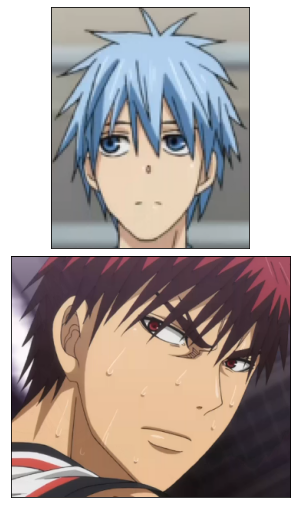

In [ ]:
# 각 카테고리의 한 레이블이 있는 DataFrame 만들기
df_unique = df.copy().drop_duplicates(subset=["Label"]).reset_index()

# 데이터 세트의 40개 사진 표시
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    # ax.set_title(df_unique.Label[i])
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
# 테스트 데이터가 따로 있어서 실행 안함
# 트레인, 테스트가 합쳐져 있을 경우, 사용하고 아래 셀에서 validation을 나눠주기 때문에 여기서는 train/test로만 나누면 됨
# Separate in train and test data
# train_df, test_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=0)

In [ ]:
# Genenrator 사용

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='training',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    subset='validation',
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 80 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.
Found 20 validated image filenames belonging to 2 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x) # Dense는 출력되는 수에 맞춰주기/활성화 함수는 출력수가 2개라서 시그모이드 사용

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10
3/3 [==============================] - 8s 2s/step - loss: 0.5381 - accuracy: 0.7000 - val_loss: 0.1885 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.1288 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 3s 1s/step - loss: 0.0197 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 3s 1s/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 3s 1s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 7.9684e-04 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 3s 1s/step - loss: 5.3097e-04 - accuracy: 1.0000 - val_loss: 3.4773e-04 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 3s 1s/step - loss: 2.7405e-04 - accuracy: 1.0000 - val_loss: 1.9341e-04 - val_accuracy: 1.0000
Epoch 8/10
3/3 [=====

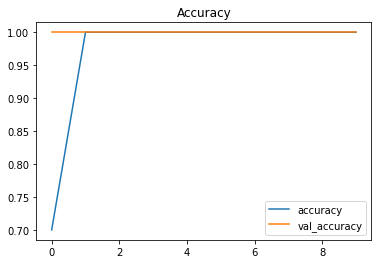

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

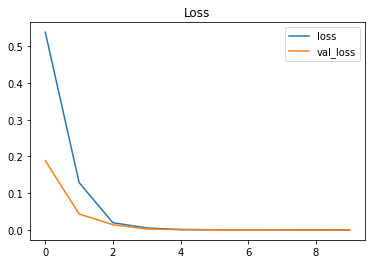

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# 테스트 이미지 예측
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# 레이블 매핑
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# 결과
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: ['kuroko', 'kuroko', 'kagami', 'kuroko', 'kagami']


In [ ]:
from sklearn.metrics import accuracy_score
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)
print(f'Accuracy on the test set: {acc * 100:.2f}%')

Accuracy on the test set: 100.00%


In [ ]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, pred, zero_division=1)
print(class_report)

              precision    recall  f1-score   support

      kagami       1.00      1.00      1.00        10
      kuroko       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



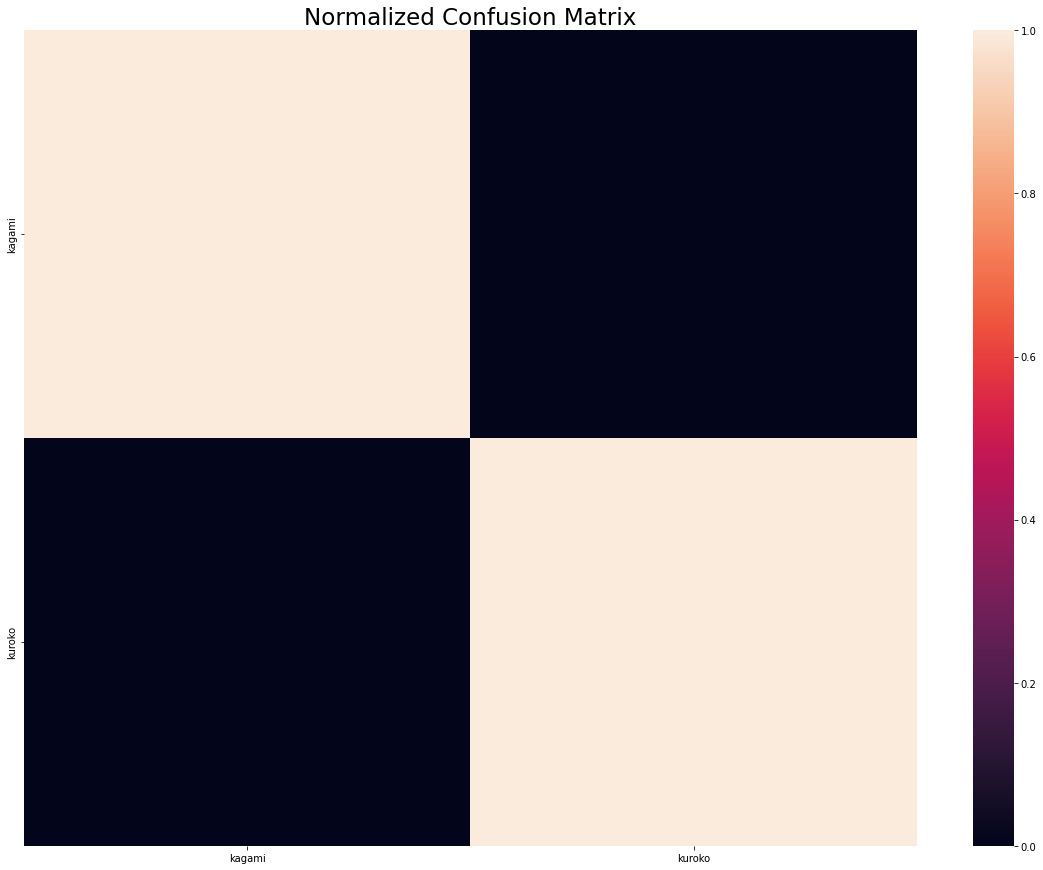

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (20,15))
sns.heatmap(cf_matrix, annot=False, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.show()

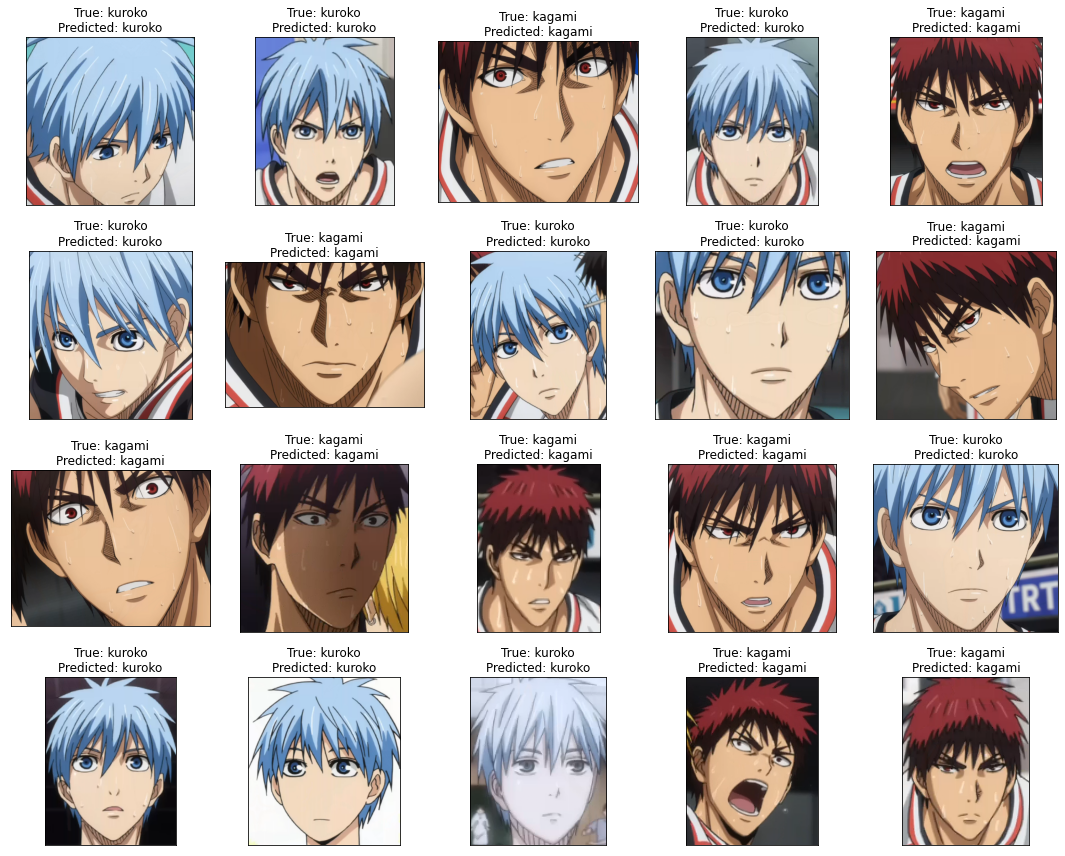

In [ ]:
# Display 15 picture of the dataset with their labels
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 12),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}")
plt.tight_layout()
plt.show()